<a href="https://www.kaggle.com/code/argada/public-weight-tracking?scriptVersionId=194287793" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
import os
from typing import List

Read weight log 
``` python
file_path = '/kaggle/input/weight-log/weight__log.csv'
wl_d = pd.read_csv(file_path, parse_dates=['ymd'])
wl_d.head(15)
```

Create weight log
``` python
wl = {'ymd': [20240101, 20240102, 20240103, 20240104, 20240105] , 
      'day_of_cicle': [5, 6, 7, 8, 9], #if you wish to track it 
      'weight' : [80, 82, 81, 80, 82 ],
      'calories' : [2000, 2000, 2000, 2000, 2000],
      'exersize' : [4, 4, 4, 3,5],
      'protein' : [80, 82, 81, 80, 82 ],
     }
wl_d = pd.DataFrame(data=wl, index=[i for i in range(5)])
wl_d['ymd'] = pd.to_datetime(wl_d['ymd'].astype(str), format='%Y%m%d')
file_path = './weight_log.csv'
wl_d.to_csv(file_path, index=False)

```

# Dummy dataset 

In [2]:
n = 7*12 # Tracking for 12 weeks n = 7*12 
cicle = ([30, 7], np.arange(1, 31))
day_of_cicle = np.tile(cicle[1], (n+9 // cicle[0][0]) + 1)[9:n+9]
random_week = np.random.rand(7)
week_trend = np.array([random_week[i%7] for i in range(n)])
wl = {'ymd': pd.date_range(start='2024-01-01', periods=n), 
      'day_of_cicle': day_of_cicle,
      'weight' : 70+0.5*np.cos(day_of_cicle*2*np.pi/cicle[0][0]) - 0.06*np.arange(n) - 0.5*np.sin(np.random.rand(n)*np.pi + 0.3*np.roll(week_trend, 1)),
      'calories' : 1800+500*np.random.rand(n) + 150*week_trend+100*np.cos(day_of_cicle*2*np.pi/cicle[0][0]),
      'exersize' : (6*np.random.rand(n)).astype(int),
      'protein' : np.round(60+ 40*np.random.rand(n)+ 5*week_trend, 1) ,
     }
wl_d = pd.DataFrame(data=wl, index=[i for i in range(n)])
wl_d.head(5)

,ymd,day_of_cicle,weight,calories,exersize,protein
0,2024-01-01,10,69.291686,1851.361943,1,82.0
1,2024-01-02,11,69.190537,2196.609973,3,94.7
2,2024-01-03,12,68.977072,2013.771928,2,68.5
3,2024-01-04,13,68.935163,1857.698599,1,91.6
4,2024-01-05,14,68.785941,1994.187183,0,70.9


# Tracking weight and calories

In [3]:
shades_of_rate = np.linspace(np.array([30, 132, 73]), np.array([8, 143, 143]), 5)/255
rates = np.array([0.99+0.002*i for i in range(5)])**(1/7)
rates_name = [f'Change rate {1-i*0.02}%' for i in range(5)]

def shades(ax: plt.Axes, 
           df: pd.DataFrame, 
           date_name: str = 'ymd', 
           slot: List[int] = [1, 6],
           cl: str = 'salmon'
           ) -> None:
    '''
    draws shades for the cicle
    '''
    mask = (df['day_of_cicle'] <= slot[1]) & (df['day_of_cicle'] >= slot[0])
    intervals = df[mask][date_name]
    new_day = df[mask][intervals.diff().dt.days > 1].index
    for i in new_day:
        ax.fill_between(intervals.loc[:i-1], 0, 100, color=cl, alpha=0.05)
        intervals = intervals.loc[i:]
    ax.fill_between(intervals, 0, 100, color=cl, alpha=0.1)



def make_tracking_plot(df: pd.DataFrame, d_w_c_p: List[str] = ['ymd', 'weight', 'calories', 'protein']) -> None:
    # Plot body  
    fig, ax = plt.subplots(figsize=(16, 9))
    fig.subplots_adjust(right=0.75)
 
    twin1 = ax.twinx()
    twin2 = ax.twinx()
    twin2.spines.right.set_position(("axes", 1.2))

    ax.set( ylim=(df[d_w_c_p[1]].min()-10*df[d_w_c_p[1]].std(), 1.02*df[d_w_c_p[1]].max()), ylabel=d_w_c_p[1].capitalize(), xlabel="Time")
    twin1.set(ylim=(df[d_w_c_p[2]].mean()-7*df[d_w_c_p[2]].std(), df[d_w_c_p[2]].mean()+8*df[d_w_c_p[2]].std()), ylabel=d_w_c_p[2].capitalize())
    twin2.set(ylim=(0.9*df[d_w_c_p[3]].min(), df[d_w_c_p[3]].max()+10*df[d_w_c_p[3]].std()), ylabel=d_w_c_p[3].capitalize())

    ax.yaxis.label.set_color('darkgreen')
    ax.tick_params(axis='y', colors=ax.yaxis.label.get_color())
    twin1.yaxis.label.set_color('darkred')
    twin1.tick_params(axis='y', colors=twin1.yaxis.label.get_color())
    twin2.yaxis.label.set_color('darkblue')
    twin2.tick_params(axis='y', colors=twin2.yaxis.label.get_color())

    labels = sorted(df[d_w_c_p[0]].unique().astype(str)) #
    ax.set_xticks(df[d_w_c_p[0]].unique()[0::7])
    ax.set_xticklabels(labels[0::7], rotation=45, ha='right')
    plt.grid(alpha=0.1)
    
    #x - axis grid for time
    for i in df[d_w_c_p[0]].unique()[0::7]:
        ax.axvline(i, color='gray', linestyle='-', linewidth=1, alpha=0.1)
        ax.axhline


    #Rates grid
    for i in range(5):
        ax.plot(df[d_w_c_p[0]], df[d_w_c_p[1]][0]*(rates[i]**wl_d.index), '--', color=shades_of_rate[i], label=d_w_c_p[1].capitalize(), alpha=0.5 )
        ax.text(0.85, df[d_w_c_p[1]][0]*(rates[i]**wl_d.index[-1]) - 0.3, rates_name[i], color=shades_of_rate[i], fontsize=8, va='center', ha='left', transform=ax.get_yaxis_transform())

    #Variables
    p1, = ax.plot(df[d_w_c_p[0]], df[d_w_c_p[1]], '.-', color='green', label=d_w_c_p[1].capitalize())
    p2, = twin1.plot(df[d_w_c_p[0]], df[d_w_c_p[2]], '.--', color='red', label=d_w_c_p[2].capitalize())
    p3, = twin2.plot(df[d_w_c_p[0]], df[d_w_c_p[3]], '.--', color='blue', label=d_w_c_p[3].capitalize())

    #Goal
    goal_weight = 64 
    ax.axhline(goal_weight, color='green', linestyle='--', linewidth=1)
    ax.text(0.02, goal_weight + 0.5, 'Weight Goal', color='green', fontsize=10, va='center', ha='left', transform=ax.get_yaxis_transform())

    #Top text
    change = (df[d_w_c_p[1]][0] - df[d_w_c_p[1]].dropna().iloc[-1]).round(3)
    percent = np.round(100*change/df[d_w_c_p[1]][0], 1)
    ax.text(0.01, 70.25, f'Current change {change},  Loss Percentage {percent}', color='green', fontsize=8, va='center', ha='left', transform=ax.get_yaxis_transform())


    #Cicle shades
    try: 
        a = df['day_of_cicle']
        shades(ax, df)
        shades(ax, df, slot = [10, 18], cl = 'turquoise')
    except:
        print("No cicle")

    # 7 day mean
    n = wl_d.shape[0]
    weekly_means = df[d_w_c_p].groupby(np.arange(n) // 7).mean()
    #ax.plot(weekly_means[d_w_c_p[0]]-pd.DateOffset(days=2), weekly_means[d_w_c_p[1]], drawstyle='steps-mid', color='green', label=d_w_c_p[1].capitalize(), alpha=0.3)
    twin1.plot(weekly_means[d_w_c_p[0]]-pd.DateOffset(days=2), weekly_means[d_w_c_p[2]], drawstyle='steps-mid', color='red', label=d_w_c_p[2].capitalize(), alpha=0.3)
    twin2.plot(weekly_means[d_w_c_p[0]]-pd.DateOffset(days=2), weekly_means[d_w_c_p[3]], drawstyle='steps-mid', color='blue', label=d_w_c_p[3].capitalize(), alpha=0.3)
    plt.show()
    
def make_3_plots(df: pd.DataFrame, d_w_c_p: List[str] = ['ymd', 'weight', 'calories', 'protein']) -> None:
    #pass
    
    #Colors
    colors_dark = ['darkgreen', 'darkred', 'darkblue']
    colors = ['green', 'red', 'blue']
    
    #plot 
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    labels = sorted(df[d_w_c_p[0]].unique().astype(str)) #
    
    for i in range(3):
        ax[i].yaxis.label.set_color(colors_dark[i])
        ax[i].tick_params(axis='y', colors=colors_dark[i])    
        ax[i].set(ylim=(df[d_w_c_p[i+1]].mean()-4*df[d_w_c_p[i+1]].std(), df[d_w_c_p[i+1]].mean()+4*df[d_w_c_p[i+1]].std()), ylabel=d_w_c_p[i+1].capitalize(), xlabel='Time')
        ax[i].plot(df[d_w_c_p[0]], df[d_w_c_p[i+1]], '.-', color=colors[i]) #, label=d_w_c_p[i+1].capitalize() )
        ax[i].set_xticks(df[d_w_c_p[0]].unique()[0::14])
        ax[i].set_xticklabels(labels[0::14], rotation=45, ha='right')
        ax[i].grid(alpha=0.1)
    
    #Goal
    goal_weight = 64 
    ax[0].axhline(goal_weight, color=colors[0], linestyle='--', linewidth=1)
    ax[0].text(0.02, goal_weight + 0.5, 'Weight Goal', color=colors[0], fontsize=10, va='center', ha='left', transform=ax[0].get_yaxis_transform())

    av_1 = np.round(df[d_w_c_p[2]].mean(), 2)
    ax[1].axhline(av_1, color=colors[1], linestyle='--', linewidth=1)
    ax[1].text(0.5, df[d_w_c_p[2]].mean()-3*df[d_w_c_p[2]].std(), f'Avarege {d_w_c_p[2]} {av_1}', color=colors[1], fontsize=8, va='center', ha='left', transform=ax[1].get_yaxis_transform())

    av_2 = np.round(df[d_w_c_p[3]].mean(), 2)
    ax[2].axhline(av_2, color=colors[2], linestyle='--', linewidth=1)
    ax[2].text(0.5, df[d_w_c_p[3]].mean()-3*df[d_w_c_p[3]].std(), f'Avarege {d_w_c_p[3]} {av_2}', color=colors[2], fontsize=8, va='center', ha='left', transform=ax[2].get_yaxis_transform())

    
    plt.tight_layout()
    plt.show()

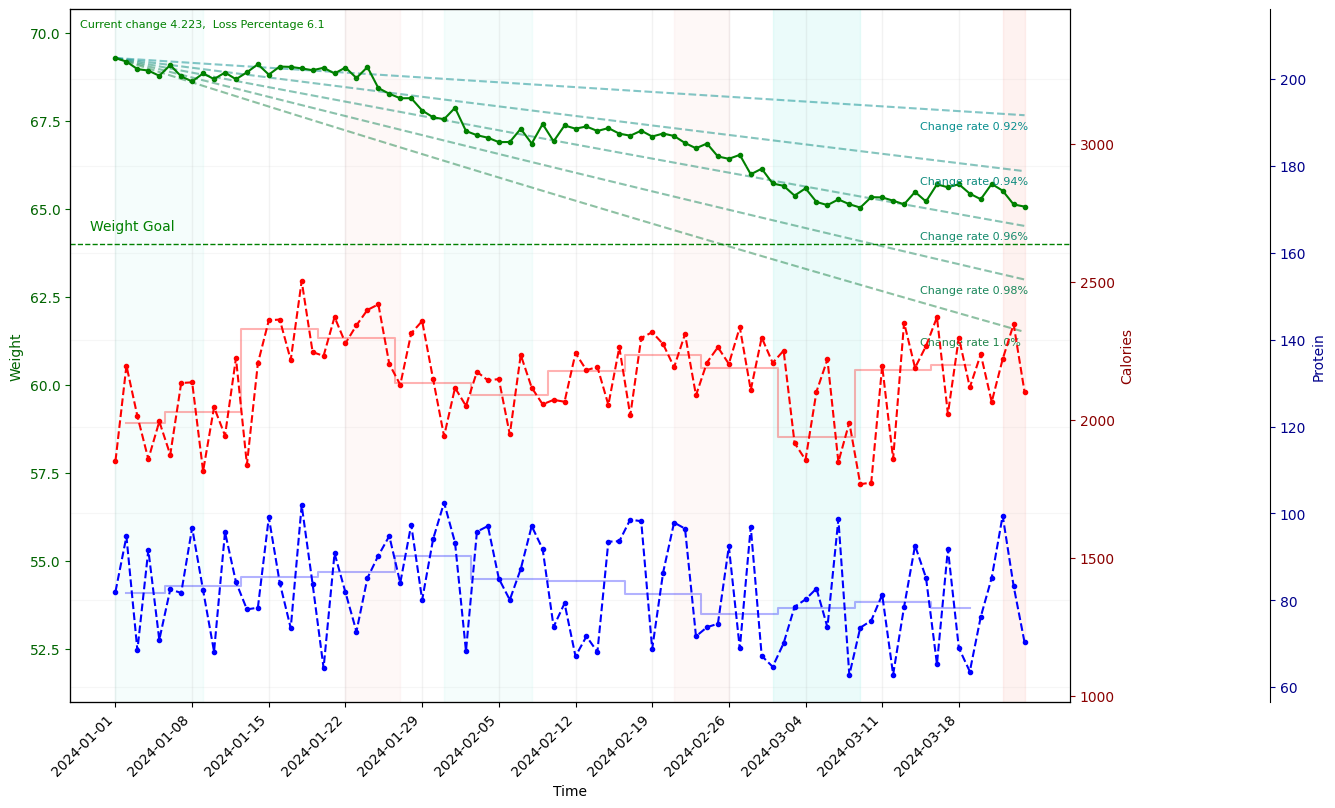

In [4]:
make_tracking_plot(wl_d)

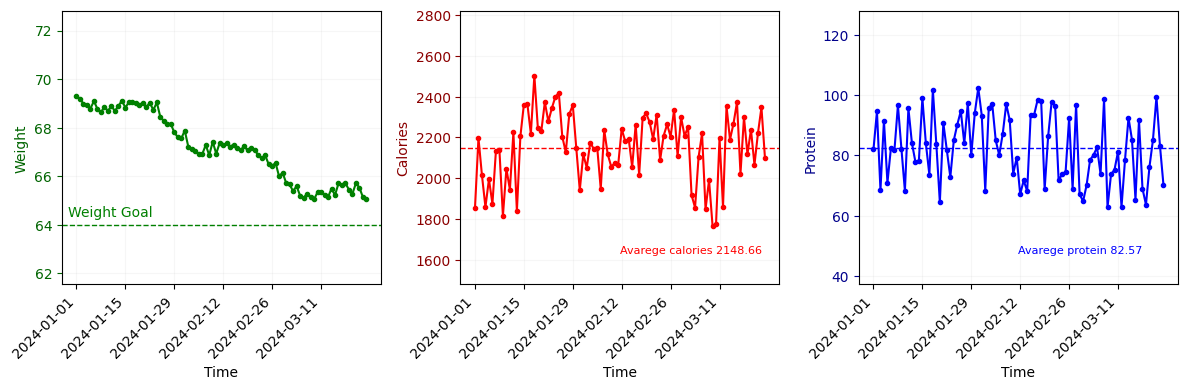

In [5]:
make_3_plots(wl_d)

# Daily calorie usage 
*Under construction* 